Anh-Nguyet Lise Nguyen

# Problem 1

## Problem 1.1

In [1]:
import numpy as np
import scipy.stats 
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn.metrics as sklm
import sklearn.linear_model as skllm
import sklearn.model_selection as sklms
import sklearn.preprocessing as sklpre
import sklearn.neighbors as skln
import sklearn.tree as skt
import sklearn.ensemble as skle
import sklearn.neural_network as sknn
import pygam 

In [2]:
%load_ext rpy2.ipython

In [3]:
# Import the .csv file for the ozone data into a data frame
df = pd.read_csv("data/ozone_496obs_25vars.txt", header=0, sep=" ")

In [4]:
# Extract variables except SEX
variables = df.loc[:,  (df.columns != "SEX")]

# Onehotting the SEX categorical variable 
onehot_sex = pd.get_dummies(df.loc[:,"SEX"]).set_axis(
    ["MALE", "FEMALE"], axis=1, inplace=False
)
# Inserting MALE and FEMALE into variable data frame
variables = variables.join(onehot_sex)


In [5]:
# Split into training and test set
variables_train_, variables_test_ = sklms.train_test_split(
    variables, test_size=0.5, stratify=variables["FSATEM"]
)

In [6]:
# Which columns to scale:
col_continuous = np.array(["ALTER", "AGEBGEW", "FLGROSS", "FNOH24", "FLTOTMED", "FO3H24", "FTEH24", "FLGEW",  "FFVC"])

# Defining the scaler (subtracts mean, divides by standard deviation):
scaler = sklpre.StandardScaler().fit(variables_train_[col_continuous].values)

# Standardizing the data using the scaler defined above in the continuous variables
scaled_cols_train = scaler.transform(variables_train_[col_continuous])
scaled_cols_test = scaler.transform(variables_test_[col_continuous])


In [7]:
# List of all variable names
feature_names = np.array(variables.columns.values, dtype=str)

# List of categorical variables
col_categorical = []
for item in feature_names:
    if item not in col_continuous:
        col_categorical.append(item)

# Data frame of the categorical variables 
variables_categorical_train = variables_train_.loc[:, col_categorical]
variables_categorical_test = variables_test_.loc[:, col_categorical]

# Data frame of the continuous variables
variables_continuous_train = pd.DataFrame(scaled_cols_train, columns=col_continuous)
variables_continuous_test = pd.DataFrame(scaled_cols_test, columns=col_continuous)

In [8]:
# Merging the categorical and continuous variables: 

variables_final_train = variables_categorical_train.join(variables_continuous_train) 
variables_final_test = variables_categorical_test.join(variables_continuous_test)

variables_train_array = np.concatenate([variables_categorical_train, variables_continuous_train], axis=1)
variables_final_train = pd.DataFrame(variables_train_array, columns=(list(col_categorical)+list(col_continuous)))

variables_test_array = np.concatenate([variables_categorical_test, variables_continuous_test], axis=1)
variables_final_test = pd.DataFrame(variables_test_array, columns=(list(col_categorical)+list(col_continuous)))

    

In [9]:
# Exporting the final preprocessed data frames as .csv 
variables_final_train.to_csv("data/ozone_train.csv", index=False)
variables_final_test.to_csv("data/ozone_test.csv", index=False)

The categorical variables were not scaled and only SEX was encoded into FEMALE and MALE. This was not necessary for the other categorical variables as they were boolean. 

## Problem 1.2

In [10]:
# Import the .csv for the training set made in Problem 1.1
df_train = pd.read_csv("data/ozone_train.csv")

# Extract explanatory features X and outcome y
X_train = df_train.loc[:, df_train.columns != "FFVC"]
y_train = df_train.loc[:, "FFVC"]


In [11]:
# Import the .csv for the test set made in Problem 1.1
df_test = pd.read_csv("data/ozone_test.csv")

# Extract explanatory features X and outcome y
X_test = df_test.loc[:, df_test.columns != "FFVC"]
y_test = df_test.loc[:, "FFVC"]


In [12]:
# Need to write my own function to return a summary of coefficients, std and p-values

def summary_OLS(X, y, feature_names):
    array_1D = None
    
    if len(np.shape(X)) == 1:
        array_1D = True
        X = X.reshape(-1,1)
    
    # Initialize OLS and calculate coefficients
    OLS = skllm.LinearRegression(fit_intercept=False).fit(X, y)
    y_pred = OLS.predict(X) 
    coefficients = np.append(OLS.intercept_, OLS.coef_)
    
    # Calculate variance and standard deviance
    newX = np.append(np.ones((len(X),1)), X, axis=1)
    MSE = (sum((y - y_pred)**2))/(len(newX)-len(newX[0]))
    
    var = MSE*(np.linalg.pinv(np.dot(newX.T,newX)).diagonal())
    std = np.sqrt(var)
    
    # Then calculate p-values
    ts_b = coefficients/ std

    p = np.zeros(len(ts_b))
    for index, i in enumerate(ts_b):
        p[index] = 2*(1-scipy.stats.t.cdf(np.abs(i),(len(newX)-1))) 
    
    # Make a data frame of coefficients, std and p-values
    if array_1D:
        summary = pd.DataFrame(zip(coefficients, std, p), columns=["Feature", "Standard deviance", "p-values"]
                              , index=(["intercept"] + [feature_names]))
        
    else:
        summary = pd.DataFrame(zip(coefficients, std, p), columns=["Coefficients", "Standard deviance", "p-values"],
                          index=(["intercept"] + list(feature_names)))
                           
    return summary
        


In [13]:
summary_train = summary_OLS(X_train, y_train, X_train.columns.values)

summary_test = summary_OLS(X_test, y_test, X_test.columns.values)

print(f"Summary for the OLS training")
summary_train

Summary for the OLS training


,Coefficients,Standard deviance,p-values
intercept,0.000000,0.063838,1.000000e+00
ADHEU,-0.251528,0.169382,1.388256e-01
HOCHOZON,-0.124647,0.108682,2.525339e-01
AMATOP,0.070164,0.093371,4.530934e-01
AVATOP,-0.006713,0.104893,9.490247e-01
ADEKZ,0.029896,0.098487,7.617231e-01
ARAUCH,-0.051224,0.085788,5.509842e-01
FSNIGHT,0.211984,0.164447,1.985788e-01
FMILB,-0.058481,0.143574,6.841216e-01
FTIER,-0.032023,0.137196,8.156339e-01


## Problem 1.3 

I'm choosing to use criterias for p-value in backward elimination and forward selection.

### Backward elimination

In [14]:
# Need to write my own backward elimination function 

def backward_elimination(X, y, alpha):
    # Make copies of X and y
    X_copy = X.copy()
    y_copy = y.copy()
    
    feature_names = X_copy.columns.values
    # Calculating coefficients, standard deviations and p-values as summary
    # of initial X and y 
    summary = summary_OLS(X_copy, y_copy, feature_names)
    p_values = summary.loc[:, "p-values"]

    # Find maximum p-value
    p_max = np.max(p_values)
    
    # Iterate until p <= alpha
    while p_max > alpha:
        # Calculating coefficients, standard deviations and p-values using summary_OLS function
        feature_names = X_copy.columns.values
        summary = summary_OLS(X_copy, y_copy, feature_names)
        summary.drop("intercept", axis=0, inplace=True)
        p_values = summary.loc[:, "p-values"]
        
        # Locating index with maximum p-value and 
        # dropping corresponding feature
        p_max_index = p_values.idxmax(axis=1)
        X_copy.drop(p_max_index, axis=1, inplace=True)
        
        # Update maximum p-value
        p_max = p_values.loc[p_max_index]        
    feature_names = X_copy.columns.values
    
    return X_copy, summary_OLS(X_copy, y_copy, feature_names)



In [15]:
X_backelim_1_train, summary_backelim_1_train = backward_elimination(X_train, y_train, 1e-1)
print("Backward elimination using threshold 0.1 \n\n", summary_backelim_1_train)

Backward elimination using threshold 0.1 

            Coefficients  Standard deviance      p-values
intercept      0.000000           0.025060  1.000000e+00
MALE           0.270255           0.040935  2.462022e-10
FEMALE        -0.233679           0.039186  8.498613e-09
FLGROSS        0.511359           0.055964  0.000000e+00
FLGEW          0.268868           0.055824  2.551946e-06


In [16]:
X_backelim_2_train, summary_backelim_2_train = backward_elimination(X_train, y_train, 1e-3)
summary_backelim_2_train

print("Backward elimination using threshold 0.001 \n\n", summary_backelim_2_train)

Backward elimination using threshold 0.001 

            Coefficients  Standard deviance      p-values
intercept      0.000000           0.026175  1.000000e+00
MALE           0.277038           0.042734  4.854697e-10
FEMALE        -0.239544           0.040907  1.506194e-08
FLGROSS        0.709517           0.039626  0.000000e+00


### Forward selection

In [17]:
# Need to write my own forward selection function

def forward_selection(X, y, alpha):
    X_copy = X.copy()
    y_copy = y.copy()
    p_max = alpha - 1
    p_min = 0
    
    feature_include = []
    feature_names = np.array(list(X_copy.columns.values))
    while p_max < alpha and len(feature_names)>0:

        n_features = len(feature_names)
        p_values = np.zeros(n_features)
        
        for i, feature in enumerate(feature_names):
            # Calculate summary (coefficients, std, p-value) for each feature
            features = np.append(feature_include, feature_names[i])
            
            X_feature = X_copy.loc[:, features].values
            summary = summary_OLS(X_feature, y_copy, features)

            summary.drop((["intercept"] + feature_include ), axis=0, inplace=True)
            
            
            p_one = summary.loc[:, "p-values"].values
            p_values[i] = p_one
            
        # Find the smallest p-value and corresponding feature
        p_min_index = np.argmin(p_values)
        p_min = p_values[p_min_index]
        
        feature_min_p = feature_names[p_min_index]
        feature_include.append(feature_min_p)
        feature_names = feature_names[feature_names != feature_min_p]

        # Calculate summary for the included features
        X_feature = X_copy.loc[:, features].values

        summary_ = summary_OLS(X_feature, y_copy, feature_include)
        
        p_max = summary.loc[:, "p-values"].values.max()

        X_final = X_copy.loc[:, feature_include]
        
    return X_final, summary_OLS(X_final, y_copy, feature_include)


In [18]:
X_forsec_1_train, summary_forsec_1_train = forward_selection(X_train, y_train, 1e-1)
print("Forward selection using threshold 0.1\n \n",summary_forsec_1_train)

Forward selection using threshold 0.1
 
            Coefficients  Standard deviance  p-values
intercept      0.000000           0.053518  1.000000
FLGROSS        0.525054           0.058168  0.000000
FLGEW          0.274859           0.058023  0.000004
MALE           0.267114           0.079119  0.000854


In [19]:
X_forsec_2_train, summary_forsec_2_train = forward_selection(X_train, y_train, 1e-3)
print(f"Forward selection using threshold 0.001\n \n",summary_forsec_2_train)

Forward selection using threshold 0.001
 
            Coefficients  Standard deviance  p-values
intercept      0.000000           0.053518  1.000000
FLGROSS        0.525054           0.058168  0.000000
FLGEW          0.274859           0.058023  0.000004
MALE           0.267114           0.079119  0.000854


It is interesting to note that using the same criteria $\alpha$ for p-value in both backward elimination and forward selection, for $\alpha=0.1$ the number of variables in the model is higher for backward elimination (6) than forward selection (3). For $\alpha=0.001$ the backward selection model contains three variables, while the forward selection contains two variables. The variable FLGROSS is included in every model and seems to be the most significant. Looking at the low p-values of the remaining variables of the new models, I think it is likely that these models will perform better than the full models, as eliminating the other variables with higher p-values is like eliminating noise. 

## Problem 1.4


In [20]:
# Need to write my own bootstrap algorithm 

def bootstrap(y, n_iter=1000):
    N = len(y)
    N_train = int(0.8*N)
    N_test = int(0.2*N)
    
    # Randomly choose indices from a list of all possible indices
    all_indices = np.arange(N)    
    indices_bootstrapped = []
    for i in range(n_iter):
        indices_train = np.random.choice(all_indices, size=N_train, replace=True)
        indices_test = np.random.choice(all_indices, size=N_test, replace=True)
        
        indices_bootstrapped.append([indices_train, indices_test])
        
    return indices_bootstrapped
    
    

In [21]:
shrinkage_param = np.logspace(-3, -1, 1000)

# Lasso with 5-fold cross validation 
reg_lasso_cv = skllm.LassoCV(alphas=shrinkage_param, cv=5, n_jobs=-1, fit_intercept=False).fit(X_train, y_train)
# calculate mean square error for the test on each fold, 
# then take the mean over all folds axis=1
MSE_lasso_cv = np.mean(reg_lasso_cv.mse_path_, axis=1)


In [22]:
# Initiate bootstrap splitting
a = bootstrap(y_train, n_iter=100)

# Then use LassoCV with the bootstrap splitting instead of CV
reg_lasso_bootstrap = skllm.LassoCV(alphas=shrinkage_param, cv=a, n_jobs=-1, fit_intercept=False).fit(X_train, y_train)
MSE_lasso_bootstrap = np.mean(reg_lasso_bootstrap.mse_path_, axis=1)

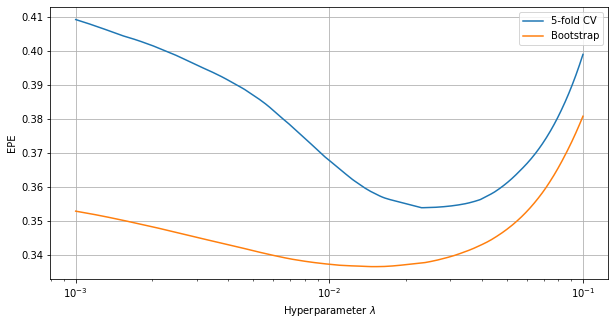

In [23]:
# Plotting expected error over hyperparameter values
figure_lasso = plt.figure(figsize=(10,5))
plt.semilogx(shrinkage_param, MSE_lasso_cv[::-1], label="5-fold CV")
plt.semilogx(shrinkage_param, MSE_lasso_bootstrap[::-1], label="Bootstrap")
plt.xlabel(r"Hyperparameter $\lambda$")
plt.ylabel("EPE")
plt.legend()
plt.grid()
plt.show()



In [24]:
print(f"The best shrinkage parameter for Lasso using CV is {reg_lasso_cv.alpha_:.2e} "+ 
      f"with R2 score of {reg_lasso_cv.score(X_test,y_test):.2f}")


print(f"The best shrinkage parameter for Lasso using bootstrap is {reg_lasso_bootstrap.alpha_:.2e} "+ 
      f"with R2 score of {reg_lasso_bootstrap.score(X_test,y_test):.2f}")

The best shrinkage parameter for Lasso using CV is 2.32e-02 with R2 score of 0.59
The best shrinkage parameter for Lasso using bootstrap is 1.49e-02 with R2 score of 0.59


From the plot, the EPE found using bootstrap is noticably lower than the EPE found using 5-fold cross validation. This is due to the severe underestimation of the EPE by the bootstrapping method, as the training and test sets are not independent. This can be improved by using e.g. 0.632 bootstrap.

## Problem 1.5

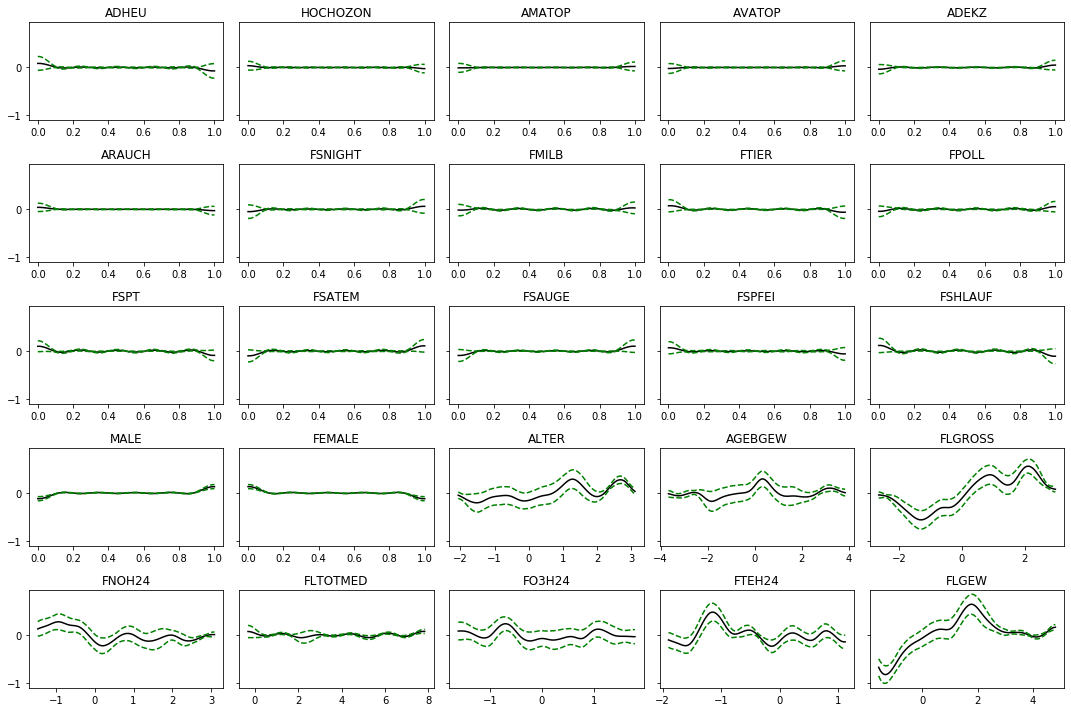

In [25]:
# Checking for linear dependence

# Fitting linear GAM 
gam_check = pygam.LinearGAM().fit(X_train.values, y_train.values)

# Plotting
fig, axes = plt.subplots(5, 5, figsize=[15, 10], sharey=True)
for i, ax in enumerate(axes.ravel()):
    XX = gam_check.generate_X_grid(i)
    pdep, confi = gam_check.partial_dependence(term=i, X=XX, width=0.95, meshgrid=False)
    ax.plot(XX[:, i], pdep, c="black")
    ax.plot(XX[:, i], confi[:, 0], c="green", ls="--")
    ax.plot(XX[:, i], confi[:, 1], c="green", ls="--")
    ax.set_title(X_train.columns.values[i])
fig.tight_layout()
plt.show()

Judging from the above plots, the variables that seem nonlinear to me are FLGROSS, FTEH24 and FLGEW.

First we try to fit a GAM:

In [26]:
nonlinear_features = ["FLGROSS", "FTEH24","FLGEW"]

# In pygam, pygam.l indicates linear, pygam.s is splines

# Initializing pygam for the first variable ADHEU, which is linear:
gam_feature_type =  pygam.l(0)

# Then for the rest of the features:
for i, feature in enumerate(X_train.columns.values[1:]):
    # Splines for non-linear features
    if feature in nonlinear_features:
        gam_feature_type +=  pygam.s(i, spline_order=3, n_splines=5)
    #  And linear for the others
    else:
        gam_feature_type += pygam.l(i)

        
# Grid search over penalties in log space and train the model
penalties = np.logspace(-5, 2, 150)        
gam = pygam.LinearGAM(gam_feature_type).gridsearch(
    X_train.values, y_train.values, lam=penalties
)



100% (150 of 150) |######################| Elapsed Time: 0:00:15 Time:  0:00:15


There apparently is a [bug](https://github.com/dswah/pyGAM/blob/master/pygam/pygam.py#L1672) in the pygam library where the p-values are incorrectly calculated and underestimated, so I have chosen not to include those results as the p-values would be lower than they should and would not be meaningful to interpret. 

In [27]:
r2_test_gam = gam._estimate_r2(X_test.values, y_test.values)["explained_deviance"]
r2_train_gam = gam._estimate_r2(X_train.values, y_train.values)["explained_deviance"]
print(f"R^2 score test: {r2_test_gam:.2f}, R^2 score train: {r2_train_gam:.2f}")

R^2 score test: 0.57, R^2 score train: 0.64


Now we will try to add non-linear terms to the linear model:

In [28]:
# First need to undo the scaling and centering of the data for training and test set:
variables_train_new = scaler.inverse_transform(
    variables_final_train.loc[:, col_continuous]
)

variables_test_new = scaler.inverse_transform(
    variables_final_test.loc[:, col_continuous]
)

# Turn into dataframes 
variables_train_new_df = pd.DataFrame(variables_train_new, columns=list(col_continuous))
variables_test_new_df = pd.DataFrame(variables_test_new, columns=list(col_continuous))



In [29]:
X_train_new = variables_train_new_df.loc[:, variables_train_new_df.columns!="FFVC"]
X_test_new = variables_test_new_df.loc[:, variables_test_new_df.columns!="FFVC"]

features_continuous = col_continuous[col_continuous!="FFVC"]

X_nonlinear_train = []
X_nonlinear_test = []
nonlinear_names = []

# Looping to add 2nd and 3rd degree order features of the ones I identified 
# earlier as non-linear and adding to a list
for i, feature in enumerate(features_continuous):
    if feature in nonlinear_features:
        # Adding 2nd degree to the features 
        X_nonlinear_train.append(X_train_new.values[:, i]**2)
        X_nonlinear_test.append(X_test_new.values[:, i]**2)
        nonlinear_names.append(feature + "^2")
        # Adding 3rd degree to the features 
        X_nonlinear_train.append(X_train_new.values[:, i]**3)
        X_nonlinear_test.append(X_test_new.values[:, i]**3)
        nonlinear_names.append(feature + "^3")

# Convert list into arrays, transpose arrays to get them in the right dimensions        
X_nonlinear_train = np.array(X_nonlinear_train).T
X_nonlinear_test = np.array(X_nonlinear_test).T

In [30]:
# Now we need to scale and center the new non-linear terms:
scaler_nonlinear = sklpre.StandardScaler().fit(X_nonlinear_train)

X_nonlinear_train_scaled = scaler_nonlinear.transform(X_nonlinear_train)
X_nonlinear_test_scaled = scaler_nonlinear.transform(X_nonlinear_test)

# Turn into data frames of non-linear features
X_nonlinear_train_scaled_df = pd.DataFrame(X_nonlinear_train_scaled, columns = nonlinear_names)
X_nonlinear_test_scaled_df = pd.DataFrame(X_nonlinear_test_scaled, columns = nonlinear_names)


In [31]:
# Join the new non-linear features with the old linear ones 
X_train_nonlinear = X_train.join(X_nonlinear_train_scaled_df)

X_test_nonlinear = X_test.join(X_nonlinear_test_scaled_df)

# Calculate coefficients, std and p-values
summary_nonlinear = summary_OLS(X_train_nonlinear, y_train, X_train_nonlinear.columns.values)

OLS_nonlinear = skllm.LinearRegression(fit_intercept=False).fit(X_train_nonlinear, y_train)
print(f"R^2 score for nonlinear model: {OLS_nonlinear.score(X_test_nonlinear, y_test)}")

summary_nonlinear

R^2 score for nonlinear model: 0.5874063724704847


,Coefficients,Standard deviance,p-values
intercept,0.000000,0.065415,1.000000e+00
ADHEU,-0.179655,0.168157,2.863953e-01
HOCHOZON,-0.054679,0.111131,6.231376e-01
AMATOP,0.063849,0.092787,4.920193e-01
AVATOP,0.055338,0.104488,5.968597e-01
ADEKZ,0.053905,0.097556,5.810695e-01
ARAUCH,-0.010327,0.085392,9.038379e-01
FSNIGHT,0.201401,0.161667,2.140253e-01
FMILB,0.006420,0.143176,9.642692e-01
FTIER,-0.049198,0.135242,7.163383e-01


Looking at the $R^2$ score for the non-linear model, it does not seem to perform better than our previous models either, but seems to perform on par with the others. What is interesting is that the p-value for FLGEW^2 and FLGEW^3 seem to be rather low, so perhaps using these non-linear features with a penalized regression method such as the Lasso or the forward selection and backward elimination methods would yield better results. 

## Problem 1.6

Apparently, Python doesn't have any well-known libraries for boosting, so this was done using R with Jupyter Notebook. Using %%R at the top of the cell transforms the entire cell into an R cell. 

In [32]:
%%R -i df_train -i df_test

library(compboost)
library(ggplot2)


In [33]:
%%R

linear_boost <- boostLinear(data = df_train, target = "FFVC", loss = LossQuadratic$new(), trace=10)

linear_boost$getEstimatedCoef()

  1/100: risk = 0.47
 10/100: risk = 0.32
 20/100: risk = 0.25
 30/100: risk = 0.22
 40/100: risk = 0.2
 50/100: risk = 0.19
 60/100: risk = 0.18
 70/100: risk = 0.17
 80/100: risk = 0.17
 90/100: risk = 0.17
100/100: risk = 0.17


Train 100 iterations in 0 Seconds.
Final risk based on the train set: 0.17

$AGEBGEW_linear
              [,1]
[1,] -1.203536e-18
[2,]  8.236995e-03

$ALTER_linear
              [,1]
[1,] -1.472307e-17
[2,]  1.930911e-02

$FEMALE_linear
           [,1]
[1,]  0.1892782
[2,] -0.3529398

$FLGEW_linear
             [,1]
[1,] 2.085534e-17
[2,] 2.511648e-01

$FLGROSS_linear
              [,1]
[1,] -1.170800e-16
[2,]  4.631095e-01

$FNOH24_linear
              [,1]
[1,]  1.412964e-17
[2,] -5.681454e-02

$MALE_linear
            [,1]
[1,] -0.02164369
[2,]  0.04667508

$offset
[1] -1.360919e-15



In [34]:
%%R
spline_boost <- boostSplines(data = df_train, target = "FFVC", loss = LossQuadratic$new(), trace=10)

table(spline_boost$getSelectedBaselearner())

  1/100: risk = 0.47
 10/100: risk = 0.31
 20/100: risk = 0.24
 30/100: risk = 0.2
 40/100: risk = 0.18
 50/100: risk = 0.17
 60/100: risk = 0.16
 70/100: risk = 0.15
 80/100: risk = 0.14
 90/100: risk = 0.14
100/100: risk = 0.14


Train 100 iterations in 0 Seconds.
Final risk based on the train set: 0.14


AGEBGEW_spline   ALTER_spline  FEMALE_spline   FLGEW_spline FLGROSS_spline 
            10             12             10             17             24 
 FNOH24_spline  FTEH24_spline    MALE_spline 
             6             16              5 


For component-wise boosting with trees, I wasn't able to find a similar method in the compboost package for R. Looking online, I did manage to find [mboost](https://cran.r-project.org/web/packages/mboost/mboost.pdf) which says it uses "component-wise (penalized) least squares estimates or regression trees as base-learners", so I hope it is correct to use this package for this purpose. I was not able to download this package, however. I tried troubleshooting this, but was not able to make it work. Sorry!


In [35]:
%%R 
library(mboost)

tree_boost <- blackboost(data=df_train, target="FFVC")

R[write to console]: Error in library(mboost) : there is no package called ‘mboost’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library




Error in library(mboost) : there is no package called ‘mboost’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library


## Problem 1.7

In [36]:
# MSE for full OLS model 
OLS = skllm.LinearRegression()


OLS_full = OLS.fit(X_train, y_train)

y_OLS_train = OLS_full.predict(X_train)
MSE_OLS_train = sklm.mean_squared_error(y_train, y_OLS_train)

y_OLS_test = OLS_full.predict(X_test)
MSE_OLS_test = sklm.mean_squared_error(y_test, y_OLS_test)

print(f"MSE test for full OLS model: {MSE_OLS_test:.2f}")
print(f"MSE train for full OLS model: {MSE_OLS_train:.2f}\n")


# MSE for backward elimination model
OLS_backelim_1 = OLS.fit(X_backelim_1_train, y_train)

y_OLS_backelim_1_train = OLS_backelim_1.predict(X_backelim_1_train)
MSE_OLS_backelim_1_train = sklm.mean_squared_error(y_train, y_OLS_backelim_1_train)

features_backelim_1 = X_backelim_1_train.columns.values

X_backelim_1_test = X_test.loc[:, features_backelim_1]
y_OLS_backelim_1_test = OLS_backelim_1.predict(X_backelim_1_test)
MSE_OLS_backelim_1_test = sklm.mean_squared_error(y_test, y_OLS_backelim_1_test)

print(f"MSE train for backwards elimination model using threshold = 0.1: {MSE_OLS_backelim_1_train:.2f}")
print(f"MSE test for backwards elimination model using threshold = 0.1: {MSE_OLS_backelim_1_test:.2f}\n")


# MSE for backward elimination model. 
OLS_backelim_2 = OLS.fit(X_backelim_2_train, y_train)

y_OLS_backelim_2_train = OLS_backelim_2.predict(X_backelim_2_train)
MSE_OLS_backelim_2_train = sklm.mean_squared_error(y_train, y_OLS_backelim_2_train)

features_backelim_2 = X_backelim_2_train.columns.values

X_backelim_2_test = X_test.loc[:, features_backelim_2]
y_OLS_backelim_2_test = OLS_backelim_2.predict(X_backelim_2_test)
MSE_OLS_backelim_2_test = sklm.mean_squared_error(y_test, y_OLS_backelim_2_test)

print(f"MSE train for backwards elimination model using threshold = 0.01: {MSE_OLS_backelim_2_train:.2f}")
print(f"MSE test for backwards elimination model using threshold = 0.01: {MSE_OLS_backelim_2_test:.2f}\n")

# MSE for forward selection model
OLS_forsec_1 = OLS.fit(X_forsec_1_train, y_train)

y_OLS_forsec_1_train = OLS_forsec_1.predict(X_forsec_1_train)
MSE_OLS_forsec_1_train = sklm.mean_squared_error(y_train, y_OLS_forsec_1_train)

features_forsec_1 = X_forsec_1_train.columns.values

X_forsec_1_test = X_test.loc[:, features_forsec_1]
y_OLS_forsec_1_test = OLS_forsec_1.predict(X_forsec_1_test)
MSE_OLS_forsec_1_test = sklm.mean_squared_error(y_test, y_OLS_forsec_1_test)


print(f"MSE train for forward selection model using threshold = 0.1: {MSE_OLS_forsec_1_train:.2f}")
print(f"MSE test for forward selection model using threshold = 0.1: {MSE_OLS_forsec_1_test:.2f}\n")


OLS_forsec_2 = OLS.fit(X_forsec_2_train, y_train)

y_OLS_forsec_2_train = OLS_forsec_2.predict(X_forsec_2_train)
MSE_OLS_forsec_2_train = sklm.mean_squared_error(y_train, y_OLS_forsec_2_train)

features_forsec_2 = X_forsec_2_train.columns.values

X_forsec_2_test = X_test.loc[:, features_forsec_2]
y_OLS_forsec_2_test = OLS_forsec_2.predict(X_forsec_2_test)
MSE_OLS_forsec_2_test = sklm.mean_squared_error(y_test, y_OLS_forsec_2_test)


print(f"MSE train for forward selection model using threshold = 0.01: {MSE_OLS_forsec_2_train:.2f}")
print(f"MSE test for forward selection model using threshold = 0.01: {MSE_OLS_forsec_2_test:.2f}\n")

# MSE for Lasso model 

# reg_lasso_cv instance was already defined and fitted earlier, so we can just call on it again
y_lasso_cv_train = reg_lasso_cv.predict(X_train)
MSE_lasso_cv_train = sklm.mean_squared_error(y_train, y_lasso_cv_train)

y_lasso_cv_test = reg_lasso_cv.predict(X_test)
MSE_lasso_cv_test = sklm.mean_squared_error(y_train, y_lasso_cv_test)

print(f"MSE train for Lasso model using CV: {MSE_lasso_cv_train:.2f}")
print(f"MSE test for Lasso model using CV: {MSE_lasso_cv_test:.2f}\n")


# reg_lasso_bootstrap instance was also defined and fitted earlier
y_lasso_bootstrap_train = reg_lasso_bootstrap.predict(X_train) 
MSE_lasso_bootstrap_train = sklm.mean_squared_error(y_train, y_lasso_bootstrap_train)

y_lasso_bootstrap_test = reg_lasso_bootstrap.predict(X_test)
MSE_lasso_bootstrap_test = sklm.mean_squared_error(y_test, y_lasso_bootstrap_test)


print(f"MSE train for Lasso model using bootstrapping: {MSE_lasso_bootstrap_train:.2f}")
print(f"MSE test for Lasso model using bootstrapping: {MSE_lasso_bootstrap_test:.2f}\n")



# MSE for GAM model 

# gam instance was already defined and fitted earlier
y_gam_train = gam.predict(X_train)
MSE_gam_train = sklm.mean_squared_error(y_train, y_gam_train)

y_gam_test = gam.predict(X_test)
MSE_gam_test = sklm.mean_squared_error(y_train, y_gam_test)


print(f"MSE train for GAM model: {MSE_gam_train:.2f}")
print(f"MSE test for GAM model: {MSE_gam_test:.2f}\n")

# MSE for non-linear model 

# OLS_nonlinear instance was already defined and fitted earlier

y_nonlinear_train = OLS_nonlinear.predict(X_train_nonlinear)
MSE_nonlinear_train = sklm.mean_squared_error(y_train, y_nonlinear_train)

y_nonlinear_test = OLS_nonlinear.predict(X_test_nonlinear)
MSE_nonlinear_test = sklm.mean_squared_error(y_test, y_nonlinear_test)

print(f"MSE train for nonlinear model: {MSE_nonlinear_train:.2f}")
print(f"MSE test for nonlinear model: {MSE_nonlinear_test:.2f}\n")


# MSE for linear boosting model

y_linearboost_train = %R linear_boost$predict(df_train)
MSE_linearboost_train = sklm.mean_squared_error(y_train, y_linearboost_train)

y_linearboost_test = %R linear_boost$predict(df_test)
MSE_linearboost_test = sklm.mean_squared_error(y_test, y_linearboost_test)


print(f"MSE train for linear boosting model: {MSE_linearboost_train:.2f}")
print(f"MSE test for linear boosting model: {MSE_linearboost_test:.2f}\n")


# MSE for splines boosting model

y_splineboost_train = %R spline_boost$predict(df_train)
MSE_splineboost_train = sklm.mean_squared_error(y_train, y_splineboost_train)

print(f"MSE train for spline boosting model: {MSE_splineboost_train:.2f}")

#y_splineboost_test = %R spline_boost$predict(df_test)
#MSE_splineboost_test = sklm.mean_squared_error(y_test, y_splineboost_test)
# Sadly, trying to get test error crashes the program? So I guess I can't answer that part

MSE test for full OLS model: 0.38
MSE train for full OLS model: 0.31

MSE train for backwards elimination model using threshold = 0.1: 0.34
MSE test for backwards elimination model using threshold = 0.1: 0.37

MSE train for backwards elimination model using threshold = 0.01: 0.37
MSE test for backwards elimination model using threshold = 0.01: 0.40

MSE train for forward selection model using threshold = 0.1: 0.34
MSE test for forward selection model using threshold = 0.1: 0.37

MSE train for forward selection model using threshold = 0.01: 0.34
MSE test for forward selection model using threshold = 0.01: 0.37

MSE train for Lasso model using CV: 0.33
MSE test for Lasso model using CV: 1.50

MSE train for Lasso model using bootstrapping: 0.33
MSE test for Lasso model using bootstrapping: 0.38

MSE train for GAM model: 0.36
MSE test for GAM model: 1.42

MSE train for nonlinear model: 0.29
MSE test for nonlinear model: 0.38

MSE train for linear boosting model: 0.34
MSE test for linear bo

For the boost model errors, I needed to export the models written in R to Python. This was done using %R. 

The lowest MSE train was gained using boosted splines. Sadly, I can't seem to get the MSE for the test set and compare. 
A lot of the models seem to perform on par with each other. The full OLS model, Lasso model using bootstrap, boosted linear model, and non-linear model seem to perform similarly well. 

The Lasso model using CV and GAM model seem to have overfitted the data and give far higher test error than train. 

I earlier said I thought the backwards elimination and forward selection models would perform better than the standard OLS model, but it seems my threshold was too low and I ended up eliminating too many variables. Raising the threshold would probably improve these models. The backwards elimination model using the threshold = 0.1 actually performed better than the backward elimination with lower threshold and forward selection, which supports the claim that the models were too strict. 

# Problem 2

In [37]:
%%R 
library(mlbench)
data(PimaIndiansDiabetes)

In [38]:
df_pima = %R PimaIndiansDiabetes
X_pima = df_pima.loc[:, df_pima.columns!="diabetes"]
y_pima = df_pima.loc[:, "diabetes"]

# Making pos = True, neg = False, then turning into integers of 1 and 0
y_pima = (y_pima.values == "pos").astype(np.int)

# Dividing into training and test sets with same proportion of positive/negative diabetes and training size 2/3
Xp_train_, Xp_test_, yp_train, yp_test = sklms.train_test_split(X_pima, y_pima, stratify=y_pima, test_size=1/3)


In [39]:
# Define the scaler
scaler_p = sklpre.StandardScaler().fit(Xp_train_)

# Scale the data with respect to Xp_train 
Xp_train_scaled = scaler_p.transform(Xp_train_)
Xp_test_scaled = scaler_p.transform(Xp_test_)

# Turn back into data frames
Xp_train = pd.DataFrame(Xp_train_scaled, columns=X_pima.columns)
Xp_test = pd.DataFrame(Xp_test_scaled, columns=X_pima.columns)

## Problem 2.1

In [40]:
# Creating instance of kNN Classifier
kNN_model = skln.KNeighborsClassifier()

# Creating dictionary of k-values for the grid search
k_values = np.arange(1, 120)
k_grid = {"n_neighbors": k_values}

# 5-fold CV grid search
kNN_gridsearch_5 = sklms.GridSearchCV(kNN_model, param_grid=k_grid, cv=5, iid=False)

# LOO CV grid search
loo = sklms.LeaveOneOut()
kNN_gridsearch_loo = sklms.GridSearchCV(kNN_model, param_grid=k_grid, cv=loo, iid=False)

In [41]:
# Fit the models to the training data with the most optimal k value
kNN_train_cv = kNN_gridsearch_5.fit(Xp_train, yp_train)

kNN_train_loo = kNN_gridsearch_loo.fit(Xp_train, yp_train)

In [42]:
# Retrieving error rates from the CV results 
kNN_train_cv_err = 1 - kNN_train_cv.cv_results_["mean_test_score"]
kNN_train_loo_err = 1 - kNN_train_loo.cv_results_["mean_test_score"]


# Calculating test error rates
kNN_test_err = np.zeros_like(k_values, dtype=float)

for k in k_values:
    kNN_test = skln.KNeighborsClassifier(n_neighbors=k).fit(Xp_train, yp_train)
    kNN_test_err[k-1] = 1 - kNN_test.score(Xp_test, yp_test)
    


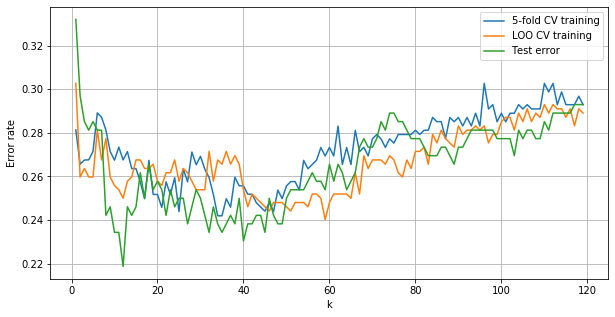

In [43]:
# Plotting the error rates over k values
figure_kNN = plt.figure(figsize=(10,5))
plt.plot(k_values, kNN_train_cv_err, label="5-fold CV training")
plt.plot(k_values, kNN_train_loo_err, label="LOO CV training")
plt.plot(k_values, kNN_test_err, label="Test error")
plt.legend()
plt.xlabel("k")
plt.ylabel("Error rate")
plt.grid()

plt.show()

5-fold CV and LOO seem to underestimate the error rate by a lot. The shape seems to be somewhat similar, which is the most important part, as we are more interested in finding the value for k that minimizes the error. These methods are okay for finding the most optimal k, but it is better to look at test error when you need to consider the actual error in the model. 

However, in this case, it seems that the kNN model is not able to get a lower error rate than approximately 0.350. The data set itself contains 768 samples, with 268 positive outcomes and we have $268/768\approx 0.349$. What probably happens is that kNN starts predicting only 0's (negative outcomes) when k is sufficiently large, and because approximately 35% of the data outcomes are 1's, the error rate becomes 35%. 

## Problem 2.2 

Considering the bug with the GAM library in Python, I can't do a subset selection, but I will still fit the model. 

In [56]:
gam_splines = pygam.s(0)

# Splines for all the features
for i in range(1, len(Xp_train.columns.values)):
    gam_splines += pygam.s(i, spline_order=2, n_splines=3)

# Range of penalties to search
penalties = np.logspace(-5, 0, 150) 
with np.errstate(invalid="ignore", divide="ignore", over="ignore"):
    # Search for optimal penalty 
    gam_p = pygam.LogisticGAM(gam_splines).gridsearch(
        Xp_train.values, yp_train, lam=penalties
    )

100% (150 of 150) |######################| Elapsed Time: 0:00:17 Time:  0:00:17


In [45]:
print(f"Train error rate using GAM: {1-gam_p.accuracy(Xp_train, yp_train)}")
print(f"Test error rate using GAM: {1-gam_p.accuracy(Xp_test, yp_test)}")

Train error rate using GAM: 0.21875
Test error rate using GAM: 0.2421875


GAM seems to perform better than kNN on the training test, but not by a lot. The test set error rate is noticably higher, indicating perhaps a slight overfit. Using subset selection would probably improve the model, but the p-value related bug in pyGAM would have left me with all the variables regardless as it is prone to  underestimating the values.

## Problem 2.3


In [46]:
# Trees
tree = skt.DecisionTreeClassifier()

# Define the range of tree depth values to grid 
tree_depths = {"max_depth": np.arange(1, 20)}

# Grid search. Uses 5-fold CV to find optimal tree depth
tree_gridsearch = sklms.GridSearchCV(
    tree, param_grid=tree_depths, cv=5, n_jobs=-1, iid=False
).fit(Xp_train, yp_train)

print(f"Best tree depth: {tree_gridsearch.best_params_}")
print(f"Tree train error rate: {1-tree_gridsearch.score(Xp_train, yp_train)}")
print(f"Tree test error rate: {1-tree_gridsearch.score(Xp_test, yp_test)}")

Best tree depth: {'max_depth': 4}
Tree train error rate: 0.185546875
Tree test error rate: 0.296875


In [47]:
# Bagging
bagging = skle.BaggingClassifier()

# Define the range of number of trees to grid
n_trees = {"n_estimators": np.arange(1, 100)}

# Grid search. Uses 5-fold CV to find optimal hyperparameter
bagging_gridsearch = sklms.GridSearchCV(
    bagging, param_grid=n_trees, cv=5, n_jobs=-1, iid=False
).fit(Xp_train, yp_train)

print(f"Best number of base estimators (bagging): {bagging_gridsearch.best_params_}")
print(f"Bagging train error rate: {1-bagging_gridsearch.score(Xp_train, yp_train)}")
print(f"Bagging test error rate: {1-bagging_gridsearch.score(Xp_test, yp_test)}")

Best number of base estimators (bagging): {'n_estimators': 61}
Bagging train error rate: 0.0
Bagging test error rate: 0.25


Note: This is only for probability. Scikit-learn does not have an implementation for consensus votes as it tends to perform worse than probability. 

In [48]:
# Random forest 
randomforest = skle.RandomForestClassifier()

# Define range of number of estimators and max tree depths to search 
hyperparams_forest = {"n_estimators": np.arange(1, 100), "max_depth": np.arange(1,30)}

# Randomized search. Uses 5-fold CV to find optimal hyperparameters
randomforest_search = sklms.RandomizedSearchCV(
    randomforest, param_distributions=hyperparams_forest, n_iter=200,cv=5, n_jobs=-1, iid=False
).fit(Xp_train, yp_train)

print(f"Best number of base estimators and max depth (random forest): {randomforest_search.best_params_}")
print(f"Random forest train error rate: {1 - randomforest_search.score(Xp_train, yp_train)}")
print(f"Random forest test error rate: {1 - randomforest_search.score(Xp_test, yp_test)}")

Best number of base estimators and max depth (random forest): {'n_estimators': 76, 'max_depth': 26}
Random forest train error rate: 0.0
Random forest test error rate: 0.25


In [49]:
# Neural network 
NN = sknn.MLPClassifier(hidden_layer_sizes=(100, 50))

# Define range of learning rate, shrinkage and batch size to search
hyperparams_nn = {
    "learning_rate_init": np.logspace(-4,0, 100), 
    "alpha": np.logspace(-4, 0, 100), 
    "batch_size":  np.arange(10, 400)
}

# Randomized search. Uses 5-fold CV to find optimal hyperparameters
NN_search = sklms.RandomizedSearchCV(
    NN, param_distributions=hyperparams_nn, cv=5, n_iter=150, n_jobs=-1, iid=False
).fit(Xp_train, yp_train)

print(f"Best learning rate, shrinkage alpha and batch size (NN): {NN_search.best_params_}")
print(f"Neural network train error rate: {1 - NN_search.score(Xp_train, yp_train)}")
print(f"Neural network test error rate: {1 - NN_search.score(Xp_test, yp_test)}")

Best learning rate, shrinkage alpha and batch size (NN): {'learning_rate_init': 0.00015922827933410923, 'batch_size': 257, 'alpha': 0.008697490026177835}
Neural network train error rate: 0.197265625
Neural network test error rate: 0.25


/home/lise/.local/share/virtualenvs/STK-IN4300-assignment2-hpF4PA7F/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [50]:
adaboost = skle.AdaBoostClassifier()

# Define range of number of estimators and learning rate to search
hyperparams_ada = {"n_estimators": np.arange(1, 300), "learning_rate": np.logspace(-4, 0, 100)}

# Randomized search. Uses 5-fold CV to find optimal hyperparameters
adaboost_search = sklms.RandomizedSearchCV(
    adaboost, param_distributions=hyperparams_ada, cv=5, n_iter=150, n_jobs=-1, iid=False
).fit(Xp_train, yp_train)

print(f"Best number of estimators and learning rate (AdaBoost): {adaboost_search.best_params_}")
print(f"AdaBoost train error rate: {1 - adaboost_search.score(Xp_train, yp_train)}")
print(f"AdaBoost test error rate: {1 - adaboost_search.score(Xp_test, yp_test)}")

Best number of estimators and learning rate (AdaBoost): {'n_estimators': 190, 'learning_rate': 0.026560877829466867}
AdaBoost train error rate: 0.21484375
AdaBoost test error rate: 0.25


## Problem 2.4

I would probably use AdaBoost, as the tree methods (Decision trees, bagging, random forests) seem to easily overfit and the neural network requires more hyperparameter tuning. AdaBoost and Neural network seem to perform practically identically in this case, but AdaBoost actually requires one fewer hyperparameter to tune, which makes it a lot more practical to use. kNN was basically useless. 

## Problem 2.5



In [51]:
%%R 
library(mlbench)
data(PimaIndiansDiabetes2)

In [52]:
df_pima2 = %R PimaIndiansDiabetes2

# Dropping all NA values
df_pima2.dropna(inplace=True)

# Then basically same process as we did for the others
X_pima2 = df_pima2.loc[:, df_pima2.columns!="diabetes"]
y_pima2 = df_pima2.loc[:, "diabetes"]

y_pima2 = (y_pima2.values == "pos").astype(int)


Xp2_train_, Xp2_test_, yp2_train, yp2_test = sklms.train_test_split(X_pima2, y_pima2, stratify=y_pima2, test_size=1/3)


# Define the scaler
scaler_p2 = sklpre.StandardScaler().fit(Xp2_train_)

# Scale the data with respect to Xp2_train 
Xp2_train_scaled = scaler_p2.transform(Xp2_train_)
Xp2_test_scaled = scaler_p2.transform(Xp2_test_)

# Turn back into data frames
Xp2_train = pd.DataFrame(Xp2_train_scaled, columns=X_pima2.columns)
Xp2_test = pd.DataFrame(Xp2_test_scaled, columns=X_pima2.columns)

Now to repeat all the methods:

In [58]:
# GAM 
gam_splines2 = pygam.s(0)

for i in range(1, len(Xp2_train.columns.values)):
    gam_splines2 += pygam.s(i, spline_order=2, n_splines=3)

with np.errstate(invalid="ignore", divide="ignore", over="ignore"):
    gam_p2 = pygam.LogisticGAM(gam_splines2).gridsearch(
        Xp2_train.values, yp2_train, lam=penalties
    )
    
print(f"Train error rate using GAM: {1-gam_p2.accuracy(Xp2_train, yp2_train)}")
print(f"Test error rate using GAM: {1-gam_p2.accuracy(Xp2_test, yp2_test)}\n")


# kNN
kNN2_gridsearch_5 = sklms.GridSearchCV(kNN_model, param_grid=k_grid, cv=5, iid=False).fit(Xp2_train, yp2_train)

print(f"Best k (kNN): {kNN2_gridsearch_5.best_params_}")
print(f"kNN train error rate (kNN): {1-kNN2_gridsearch_5.score(Xp2_train, yp2_train)}")
print(f"kNN test error rate (kNN): {1-kNN2_gridsearch_5.score(Xp2_test, yp2_test)}\n")


# Trees
tree_gridsearch2 = sklms.GridSearchCV(
    tree, param_grid=tree_depths, cv=5, n_jobs=-1, iid=False
).fit(Xp2_train, yp2_train)

print(f"Best tree depth: {tree_gridsearch2.best_params_}")
print(f"Tree train error rate: {1-tree_gridsearch2.score(Xp2_train, yp2_train)}")
print(f"Tree test error rate: {1-tree_gridsearch2.score(Xp2_test, yp2_test)}\n")


# Bagging
bagging_gridsearch2 = sklms.GridSearchCV(
    bagging, param_grid=n_trees, cv=5, n_jobs=-1, iid=False
).fit(Xp2_train, yp2_train)

print(f"Best number of base estimators (bagging): {bagging_gridsearch2.best_params_}")
print(f"Bagging train error rate: {1-bagging_gridsearch2.score(Xp2_train, yp2_train)}")
print(f"Bagging test error rate: {1-bagging_gridsearch2.score(Xp2_test, yp2_test)}\n")


# Random forest 
randomforest_search2 = sklms.RandomizedSearchCV(
    randomforest, param_distributions=hyperparams_forest, n_iter=200,cv=5, n_jobs=-1, iid=False
).fit(Xp2_train, yp2_train)

print(f"Best number of base estimators and max depth (random forest): {randomforest_search2.best_params_}")
print(f"Random forest train error rate: {1 - randomforest_search2.score(Xp2_train, yp2_train)}")
print(f"Random forest test error rate: {1 - randomforest_search2.score(Xp2_test, yp2_test)}\n")


# Neural network
NN_search2 = sklms.RandomizedSearchCV(
    NN, param_distributions=hyperparams_nn, cv=5, n_iter=150, n_jobs=-1, iid=False
).fit(Xp2_train, yp2_train)

print(f"Best learning rate, shrinkage alpha and batch size (NN): {NN_search2.best_params_}")
print(f"Neural network train error rate: {1 - NN_search2.score(Xp2_train, yp2_train)}")
print(f"Neural network test error rate: {1 - NN_search2.score(Xp2_test, yp2_test)}\n")


# Adaptive boosting
adaboost_search2 = sklms.RandomizedSearchCV(
    adaboost, param_distributions=hyperparams_ada, cv=5, n_iter=150, n_jobs=-1, iid=False
).fit(Xp2_train, yp2_train)

print(f"Best number of estimators and learning rate (AdaBoost): {adaboost_search2.best_params_}")
print(f"AdaBoost train error rate: {1 - adaboost_search2.score(Xp2_train, yp2_train)}")
print(f"AdaBoost test error rate: {1 - adaboost_search2.score(Xp2_test, yp2_test)}\n")

100% (150 of 150) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


Train error rate using GAM: 0.1954022988505747
Test error rate using GAM: 0.22137404580152675

Best k (kNN): {'n_neighbors': 9}
kNN train error rate (kNN): 0.2030651340996169
kNN test error rate (kNN): 0.26717557251908397

Best tree depth: {'max_depth': 14}
Tree train error rate: 0.0
Tree test error rate: 0.29007633587786263

Best number of base estimators (bagging): {'n_estimators': 62}
Bagging train error rate: 0.0
Bagging test error rate: 0.2137404580152672

Best number of base estimators and max depth (random forest): {'n_estimators': 63, 'max_depth': 19}
Random forest train error rate: 0.0
Random forest test error rate: 0.19083969465648853



/home/lise/.local/share/virtualenvs/STK-IN4300-assignment2-hpF4PA7F/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:350: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/lise/.local/share/virtualenvs/STK-IN4300-assignment2-hpF4PA7F/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best learning rate, shrinkage alpha and batch size (NN): {'learning_rate_init': 0.0013530477745798076, 'batch_size': 386, 'alpha': 0.00025353644939701115}
Neural network train error rate: 0.01532567049808431
Neural network test error rate: 0.25190839694656486

Best number of estimators and learning rate (AdaBoost): {'n_estimators': 211, 'learning_rate': 0.026560877829466867}
AdaBoost train error rate: 0.16475095785440608
AdaBoost test error rate: 0.2137404580152672



The tree methods (single tree, bagging, random forest) are all still overfitting by a lot, with training errors all reaching 0. Of the three, the single tree is the worst model and random forest is the best. 

GAM and kNN are not able to reach as low training errors as the tree methods, but they are at least not overfitting to the same extent as the tree methods. However, their test error rates are still higher than that of the random forest model. I would say GAM actually performs better than I expected with a test error rate of 0.22. The kNN and single tree perform the worst overall, with the single tree having the largest test error rate at 0.29. 

For the chosen hyperparameters, both the neural network and AdaBoost models seem to be overfitting the data, albeit the AdaBoost to a far lesser extent than the neural network. The neural network actually performs worse than bagging and random forests due to the way neural networks overfit the data. Overall, the random forest has the lowest test error rate, while AdaBoost and bagging seem to have the same test error rate, which is quite interesting. In this particular case I guess I would have chosen the random forest model. 